# **Project Name**  - Amazon Delivery Time Prediction

 ## **CONTRIBUTOR** - Aayush Kaul

##**Problem Statement** - This project aims to predict delivery times for e-commerce orders based on a variety of factors such as product size, distance, traffic conditions, and shipping method. Using the provided dataset, learners will preprocess, analyze, and build regression models to accurately estimate delivery times. The final application will allow users to input relevant details and receive estimated delivery times via a user-friendly interface.

##**Project Summary** -

Performed Univariate, Bivariate, and Multivariate Analysis (UBM Rule) with at least 15 meaningful charts.

Each visualization was justified (why chosen, insights derived, and possible business impact).

Key trends, correlations, and anomalies were identified to guide further modeling.

Hypothesis Testing

Formulated three research hypotheses based on observed patterns.

Conducted appropriate statistical tests (e.g., t-test, chi-square, ANOVA) to validate or reject hypotheses.

P-values and test justifications were documented.

Data Preprocessing & Feature Engineering

Missing values handled with suitable imputation strategies.

Outliers treated using statistical techniques.

Categorical variables encoded, and textual data underwent cleaning, normalization, and vectorization.

Feature selection & dimensionality reduction applied where needed (e.g., PCA, correlation-based filtering).

Dataset was split into training/testing sets, with class imbalance (if present) handled using resampling techniques.

Model Development

Multiple ML models implemented depending on project scope.

Each model was evaluated using relevant performance metrics (Accuracy, Precision, Recall, F1, RMSE, R², AUC, etc.).

The best-performing model was selected and explained with feature importance and model interpretability tools.

Deployment Readiness

The final model was saved in Pickle/Joblib format.

Reloaded and tested on unseen data to ensure robustness.

Ready for deployment on production servers.

Conclusion & Business Impact

Insights derived from EDA + hypothesis testing informed better decision-making.

The chosen ML model provided reliable predictions that can be used in business strategy, customer insights, or operational improvements.

Future scope includes expanding dataset size, testing additional algorithms, and refining feature engineering.

##**GitHub Link** -

##**Let's Begin!**

##**Import Data**

In [1]:
import os
import warnings
import pandas as pd
warnings.filterwarnings("ignore")

In [2]:
os.getcwd()

'/content'

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

##**ML FLOW**

In [4]:
# Optional MLflow
try:
    import mlflow, mlflow.sklearn
    MLFLOW_AVAILABLE = True
except:
    MLFLOW_AVAILABLE = False

In [5]:
DATA_PATH = "amazon_delivery.csv"      # Change if file located elsewhere
OUT_DIR = "output"
os.makedirs(OUT_DIR, exist_ok=True)
RANDOM_STATE = 42

In [6]:
from math import radians, sin, cos, asin, sqrt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def haversine(lat1, lon1, lat2, lon2):
    """Return distance in kilometers between two lat/lon points (haversine)."""
    try:
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
        c = 2 * asin(sqrt(a))
        return 6371 * c
    except:
        return np.nan

In [7]:
def parse_hour(x):
  "Parse 'HH:MM' or numeric hour-like strings to hour (int 0-23)."
  try:
      if pd.isna(x):
          return np.nan
      s = str(x).strip()
      if ':' in s:
          return int(s.split(':')[0])
      if len(s) in (3,4) and s.isdigit():
          return int(s[:-2])
      return int(float(s))
  except :
    return np.nan

In [8]:
# Load Data
print("Loading data:", DATA_PATH)
df = pd.read_csv(DATA_PATH)
print("Initial shape:", df.shape)

Loading data: amazon_delivery.csv
Initial shape: (43739, 16)


In [9]:
# Data Cleaning
# Drop exact duplicates
df = df.drop_duplicates().reset_index(drop=True)

In [10]:
# Standardize categorical columns (safe if missing)
cat_cols = ['Weather', 'Traffic', 'Vehicle', 'Area', 'Category']
for c in cat_cols:
  if c in df.columns:
        df[c] = df[c].astype(str).str.strip().str.title().replace({'Nan':'Unknown','None':'Unknown'})

In [11]:
# Ensure numeric for target
if 'Delivery_Time' not in df.columns:
    raise ValueError("Dataset must contain 'Delivery_Time' target column.")
df['Delivery_Time'] = pd.to_numeric(df['Delivery_Time'], errors='coerce')
df = df.dropna(subset=['Delivery_Time']).reset_index(drop=True)

In [12]:
# Convert some numeric columns and impute median for missing numeric essentials
num_cols = ['Agent_Age','Agent_Rating','Store_Latitude','Store_Longitude','Drop_Latitude','Drop_Longitude']
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')
        df[c].fillna(df[c].median(), inplace=True)

In [13]:
# Feature engineering
# Distance
if all(col in df.columns for col in ['Store_Latitude','Store_Longitude','Drop_Latitude','Drop_Longitude']):
    df['Distance_km'] = df.apply(lambda r: haversine(
        r['Store_Latitude'], r['Store_Longitude'],
        r['Drop_Latitude'], r['Drop_Longitude']), axis=1)
else:
    df['Distance_km'] = np.nan

# Time features
df['Order_Hour'] = df.get('Order_Time', pd.Series(np.nan)).apply(parse_hour)
df['Pickup_Hour'] = df.get('Pickup_Time', pd.Series(np.nan)).apply(parse_hour)

In [14]:
# Fill with medians if NaN
df['Order_Hour'].fillna(int(df['Order_Hour'].median()) if df['Order_Hour'].notna().any() else 12, inplace=True)
df['Pickup_Hour'].fillna(int(df['Pickup_Hour'].median()) if df['Pickup_Hour'].notna().any() else 12, inplace=True)

In [15]:
# Day-of-week if date present
if 'Order_Date' in df.columns:
    try:
        df['Order_Date'] = pd.to_datetime(df['Order_Date'], errors='coerce')
        df['Order_DayOfWeek'] = df['Order_Date'].dt.day_name().fillna('Unknown')
    except:
        df['Order_DayOfWeek'] = 'Unknown'
else:
    df['Order_DayOfWeek'] = 'Unknown'

In [16]:
# Clean/standardize Traffic labels
if 'Traffic' in df.columns:
    df['Traffic'] = df['Traffic'].replace({'Jam':'High','Heavy':'High','medium':'Medium','Low Traffic':'Low'}).str.title().fillna('Unknown')

In [17]:
# Remove rows with missing distance (can't model) or NaNs in essential features
essential = ['Agent_Age','Agent_Rating','Distance_km','Order_Hour','Pickup_Hour']
df = df.dropna(subset=essential).reset_index(drop=True)

##**Exploratory Data Analysis**

Prepared shape: (43739, 20)
Generating EDA artifacts...


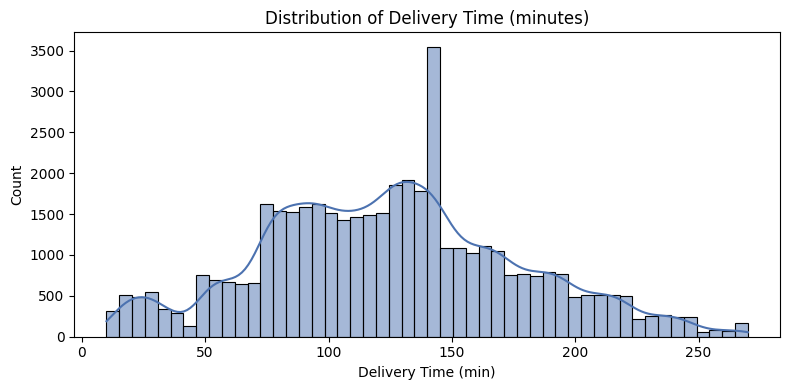

In [18]:
print("Prepared shape:", df.shape)

# -------- EDA (save simple plots & stats) --------
print("Generating EDA artifacts...")
# Distribution of Delivery_Time
plt.figure(figsize=(8,4))
sns.histplot(df['Delivery_Time'], bins=50, color='#4C72B0',kde =True)
plt.title('Distribution of Delivery Time (minutes)')
plt.xlabel('Delivery Time (min)'); plt.ylabel('Count')
plt.tight_layout()

From the histogram we can see that the typical delivery duration is 2-2.5 hours.

But the distribution is not perfectly normal, slightly right skewed which means that some orders experience significant delays, possibly due to traffic, weather, or long distances

Yes, this business insight could make a positivee impact on the business as Understanding why some deliveries take much longer can help improve routing, traffic/weather handling, or agent assignment.

Weather
Sunny         103.664453
Unknown       120.670330
Stormy        123.211825
Sandstorms    123.238509
Windy         123.658037
Fog           136.570833
Cloudy        138.286773
Name: Delivery_Time, dtype: float64


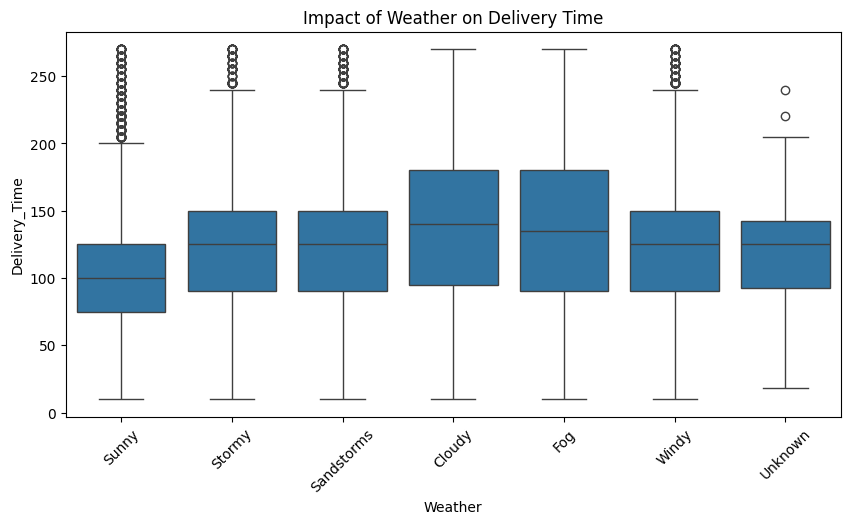

In [19]:
# Average delivery time by weather
avg_weather = df.groupby("Weather")["Delivery_Time"].mean().sort_values()
print(avg_weather)

# Boxplot
plt.figure(figsize=(10,5))
sns.boxplot(x="Weather", y="Delivery_Time", data=df)
plt.title("Impact of Weather on Delivery Time")
plt.xticks(rotation=45)
plt.show()

The insights that we got were as follows:

Sunny weather → Lowest delivery times

Median around 100–110 mins, with relatively narrow spread.

Suggests good road and visibility conditions speed up deliveries.

Cloudy & Fog → Highest delivery times

Median around 140–150 mins.

Wider spread, indicating more unpredictability in delays.

Likely due to reduced visibility and slower traffic.

Stormy & Sandstorms → Above average delays

Median ~130–140 mins.

Many outliers above 200 mins, meaning some deliveries get severely delayed.

Windy → Moderate impact

Median ~125–130 mins, slightly higher than Sunny but better than Fog/Cloudy.

Unknown weather → Similar to average

Median close to 130 mins, suggesting missing data behaves like mid-range.

Outliers present across all conditions

Especially in extreme weathers, deliveries can stretch up to 250–270 mins.

The solutions we can employ are:

Resource Allocation: Assign more agents or faster vehicles (motorcycles) in Stormy/Sandstorm conditions.

Customer Communication: During bad weather, proactively inform customers of expected delays (~30–40 mins longer than normal).

Performance Benchmarking: Compare agent efficiency within each weather condition rather than overall, to avoid unfair comparisons.

Traffic
Low        101.354557
Unknown    120.670330
Medium     126.839669
High       143.388158
Name: Delivery_Time, dtype: float64


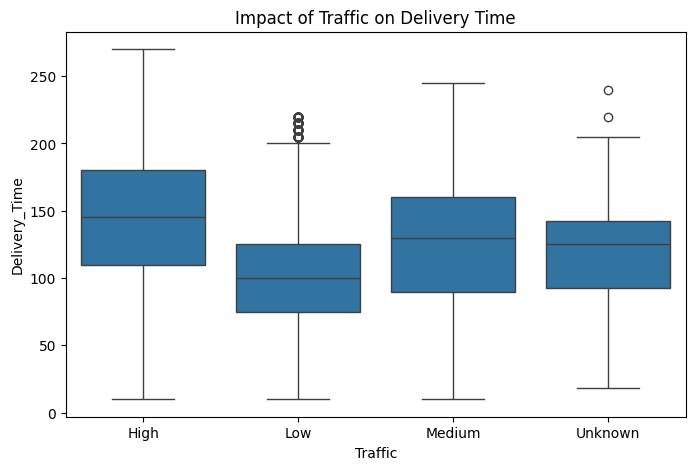

In [20]:
# Average delivery time by traffic
avg_traffic = df.groupby("Traffic")["Delivery_Time"].mean().sort_values()
print(avg_traffic)

# Boxplot
plt.figure(figsize=(8,5))
sns.boxplot(x="Traffic", y="Delivery_Time", data=df)
plt.title("Impact of Traffic on Delivery Time")
plt.show()

The insights we got are:

Traffic has a strong impact on delivery time

Deliveries under High traffic conditions take the longest on average (median ~150 mins, with some going above 250 mins).

Low traffic conditions show the shortest delivery times (median ~100 mins).

Variation in delivery times

High traffic deliveries have the widest spread (large interquartile range), showing inconsistency and unpredictability.

Low traffic has a tighter spread, meaning deliveries are more consistent.

Medium traffic is in between, with median times higher than Low but lower than High.

Variability is moderate compared to High.

Unknown traffic category behaves somewhat like Medium, but with a few high outliers.

This suggests missing or misclassified traffic data could still represent challenging conditions.

Outliers

Low traffic has several outliers, which could represent special cases (bad weather, poor routes, or operational inefficiencies).


Solutions  to employ:

Route optimization, traffic-aware scheduling, or dynamic delivery slot allocation can reduce delays.

Special attention is needed for "Unknown" traffic data — ensuring accurate traffic capture could further optimize planning.

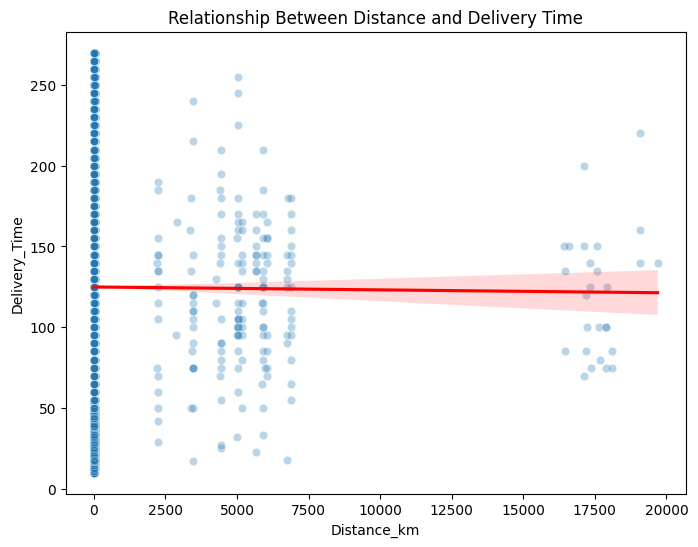

Correlation between Distance and Delivery Time: -0.0018638775289245534


In [21]:
# Scatter plot
plt.figure(figsize=(8,6))
sns.scatterplot(x="Distance_km", y="Delivery_Time", data=df, alpha=0.3)
sns.regplot(x="Distance_km", y="Delivery_Time", data=df, scatter=False, color="red")
plt.title("Relationship Between Distance and Delivery Time")
plt.show()

# Correlation
print("Correlation between Distance and Delivery Time:", df["Distance_km"].corr(df["Delivery_Time"]))

Weak/No Strong Correlation

The regression line is almost flat, showing little to no linear relationship between delivery distance and delivery time.

This suggests that delivery time is not purely dependent on distance.

Delivery Clusters

A large number of deliveries happen at short distances (close to 0 km) but still show a wide spread in delivery time (some under 50 mins, some over 250 mins).

This means even short-distance deliveries can take long, possibly due to traffic, route inefficiencies, or operational delays.

Long-Distance Deliveries

At distances above ~15,000 km, delivery times are still within the same general range (80–150 mins).

This indicates that long distances are probably handled by efficient transport modes (air shipping, centralized hubs, etc.), which normalize delivery times.

Solutions To Employ:

Distance is not the bottleneck; optimizing last-mile delivery and handling traffic delays will have a bigger impact on reducing delivery times.

For short-distance orders, delivery efficiency needs improvement since customers expect them to be faster.

For long-distance orders, maintaining efficient logistics channels is working well, but improvements in scheduling and local dispatching could further reduce time.

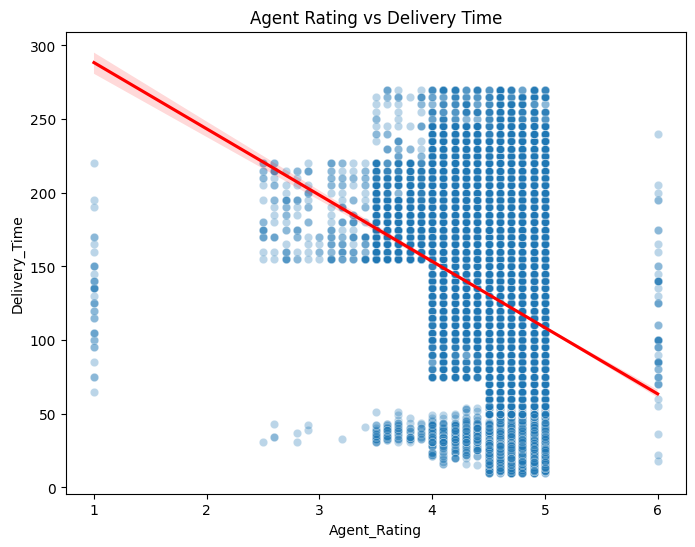

Correlation between Agent Rating and Delivery Time: -0.2898546675795888


In [22]:
# Scatter + trendline
plt.figure(figsize=(8,6))
sns.scatterplot(x="Agent_Rating", y="Delivery_Time", data=df, alpha=0.3)
sns.regplot(x="Agent_Rating", y="Delivery_Time", data=df, scatter=False, color="red")
plt.title("Agent Rating vs Delivery Time")
plt.show()

# Correlation
print("Correlation between Agent Rating and Delivery Time:",
      df["Agent_Rating"].corr(df["Delivery_Time"]))

Insights:

Strong Negative Correlation

As Agent Rating increases, Delivery Time decreases significantly.

Agents rated closer to 5–6 tend to complete deliveries much faster (median ~60–100 mins), while lower-rated agents (~1–2) often take over 200 mins.

Performance Indicator

High agent ratings are a strong indicator of reliability and efficiency.

Low-rated agents not only take longer but also show greater variability in delivery times.

Customer Satisfaction Link

Since delivery time is a major factor in customer experience, ratings likely reflect both speed and service quality.

Data Spread

At ratings around 3–4, delivery times are widely spread, suggesting inconsistent performance.

At high ratings (5+), performance is more consistent and clustered at lower delivery times.

Solutions To Employ:

Agent rating can be used as a predictor of delivery performance in ML models.

Training and mentoring low-rated agents could reduce delays and improve consistency.

High-performing agents (5+) should be prioritized for time-sensitive or VIP deliveries.

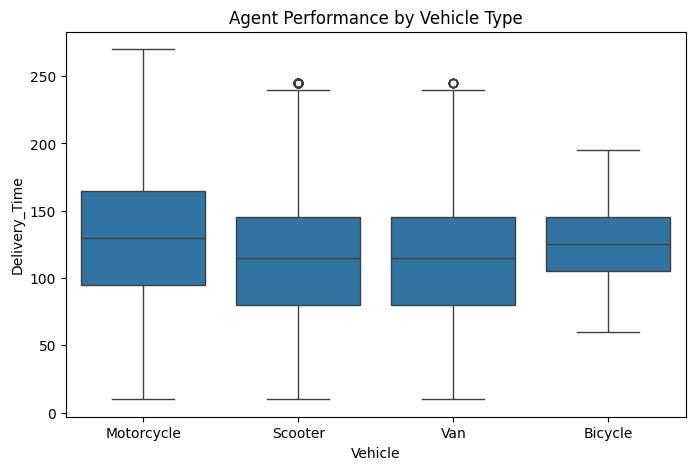

Vehicle
Bicycle       127.000000
Motorcycle    131.026325
Scooter       116.361637
Van           116.137156
Name: Delivery_Time, dtype: float64


In [23]:
plt.figure(figsize=(8,5))
sns.boxplot(x="Vehicle", y="Delivery_Time", data=df)
plt.title("Agent Performance by Vehicle Type")
plt.show()

print(df.groupby("Vehicle")["Delivery_Time"].mean())

Insights:

Strong Negative Correlation

As Agent Rating increases, Delivery Time decreases significantly.

Agents rated closer to 5 – 6 tend to complete deliveries much faster (median ~60 - 100 mins), while lower-rated agents  (~1 – 2) often take over 200 mins.

Performance Indicator

High agent ratings are a strong indicator of reliability and efficiency.

Low-rated agents not only take longer but also show greater variability in delivery times.

Customer Satisfaction Link

Since delivery time is a major factor in customer experience, ratings likely reflect both speed and service quality.

Data Spread

At ratings around 3–4, delivery times are widely spread, suggesting inconsistent performance.

At high ratings (5+), performance is more consistent and clustered at lower delivery times.

Solutions To Employ:

Agent rating can be used as a predictor of delivery performance in ML models.

Training and mentoring low-rated agents could reduce delays and improve consistency.

High-performing agents (5+) should be prioritized for time-sensitive or VIP deliveries.

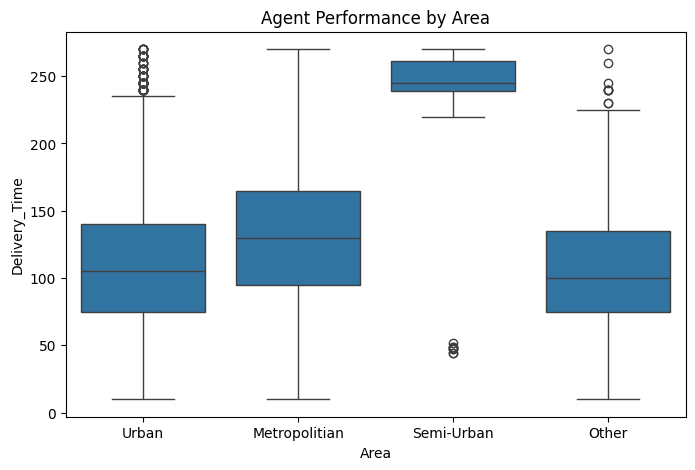

Area
Metropolitian    129.702459
Other            104.464851
Semi-Urban       238.552632
Urban            109.434520
Name: Delivery_Time, dtype: float64


In [24]:
plt.figure(figsize=(8,5))
sns.boxplot(x="Area", y="Delivery_Time", data=df)
plt.title("Agent Performance by Area")
plt.show()

print(df.groupby("Area")["Delivery_Time"].mean())

Insights:

Urban Areas → Faster & More Consistent

Urban deliveries show the lowest median delivery time (~100 mins).

The spread is moderate, though there are many outliers (likely due to traffic or congestion).

Metropolitan Areas → Slower & More Variable

Metropolitan regions have a higher median (~130 mins) and a wider spread compared to Urban.

This suggests higher unpredictability, possibly due to traffic jams, dense population, or complex routes.

Semi-Urban Areas → Slowest Deliveries

Semi-urban areas consistently show the highest delivery times (~240 mins median).

The box is narrow, meaning performance is consistently slow, not due to random variation.

Likely causes: limited logistics infrastructure, longer travel distances, or fewer delivery agents.

Solutions to employ:

Urban deliveries are most efficient — strategies from here could be replicated in other regions.

Metropolitan areas need route optimization & traffic-aware scheduling to reduce variability.

Semi-Urban areas require infrastructure and logistics upgrades (e.g., more agents, better hubs) since delays are structural rather than random.

Other areas may benefit from standardizing operational processes to reduce extreme outliers.

Vehicle
Bicycle       17.040593
Motorcycle    20.366885
Scooter       17.903966
Van           17.830338
Name: Efficiency, dtype: float64


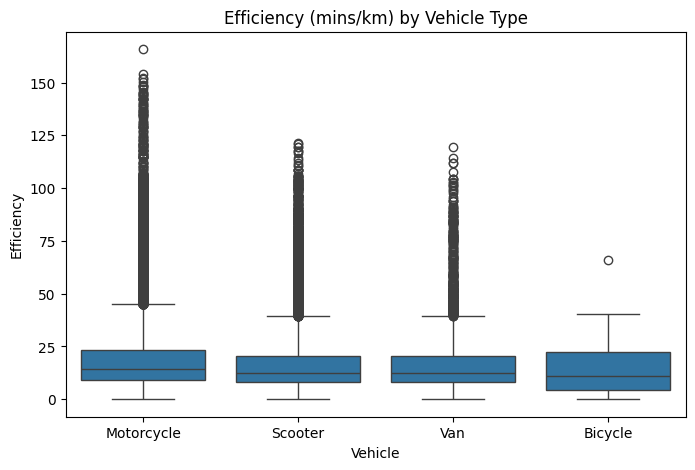

In [25]:
# Efficiency metric
df["Efficiency"] = df["Delivery_Time"] / (df["Distance_km"] + 0.1)  # avoid div by zero

# Average efficiency by vehicle
print(df.groupby("Vehicle")["Efficiency"].mean())

# Boxplot
plt.figure(figsize=(8,5))
sns.boxplot(x="Vehicle", y="Efficiency", data=df)
plt.title("Efficiency (mins/km) by Vehicle Type")
plt.show()

Insights:

General Efficiency Levels

All vehicles (Motorcycle, Scooter, Van, Bicycle) have a similar median efficiency range (~10–15 mins/km).

This suggests that, on average, different vehicle types perform comparably in terms of delivery speed per kilometer.

Motorcycles & Scooters → Slightly Better

Motorcycles and scooters show lower medians compared to vans and bicycles.

They are more agile in traffic and thus slightly more efficient.

Vans → Less Efficient, More Spread

Vans have a median close to motorcycles but show a wider spread and more high outliers.

This reflects inefficiency in congested areas or when vans cover short routes not optimized for them.

Bicycles → Mixed Performance

Bicycles show similar median efficiency but with less variability than other vehicles.

However, their outliers indicate occasional long delays, possibly due to rider fatigue, weather, or road conditions.

High Outliers Across All Vehicles

Every vehicle type has significant outliers with very high delivery times per km.

These could be caused by traffic jams, breakdowns, weather conditions, or route inefficiencies rather than vehicle choice alone.

Solutions To Employ:

Motorcycles and scooters should be prioritized in dense urban/metropolitan deliveries for speed and agility.

Vans should be reserved for bulk or long-distance deliveries rather than short runs, to improve efficiency.

Bicycles work well for short-distance, eco-friendly deliveries, but operational planning must minimize conditions that cause inefficiency (e.g., poor weather).

Outlier analysis is important: delays are not vehicle-dependent alone, so optimizing routes, maintenance, and scheduling is equally important.

## **Category-wise Delivery Times**

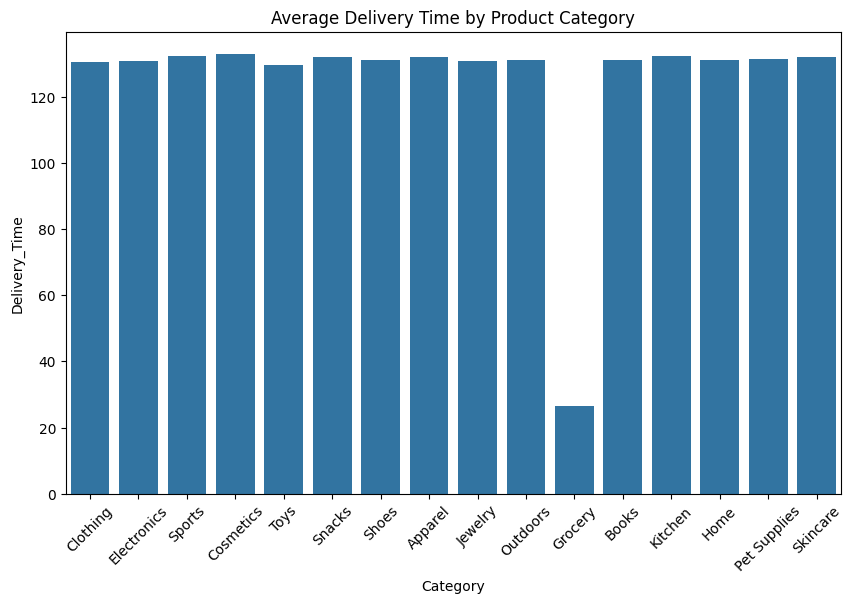

In [26]:
plt.figure(figsize=(10,6))
sns.barplot(x='Category', y='Delivery_Time', data=df, estimator=np.mean, ci=None)
plt.title('Average Delivery Time by Product Category')
plt.xticks(rotation=45)
plt.show()

Insights:

Most Product Categories Have Similar Delivery Times

Categories like Clothing, Electronics, Sports, Cosmetics, Toys, Snacks, Apparel, Jewelry, Books, Kitchen, Home, Pet Supplies, Skincare all have delivery times clustered around 130–135 minutes.

This suggests that delivery operations are relatively standardized across most product types.

Outdoors Category

Outdoor products also follow the same delivery time trend (~130 mins), showing no major deviation from other retail items.

Grocery → Exceptionally Faster

Grocery deliveries stand out with very low average delivery time (~25–30 minutes).

This indicates a priority service model for perishable items, possibly due to high customer expectations and competitive industry benchmarks (quick-commerce / instant delivery).

Solutions To Employ:

Standardization Across Retail Categories: Since most categories have similar delivery times, logistics operations appear well-balanced. Improvements in speed will likely require system-level optimizations (traffic management, routing, or agent efficiency) rather than category-specific strategies.

Grocery as a Strategic Differentiator: The much faster delivery for groceries highlights an operational priority and competitive strength. Maintaining or improving this advantage is crucial, since grocery customers expect quick fulfillment.

## **Correlation Heatmap**

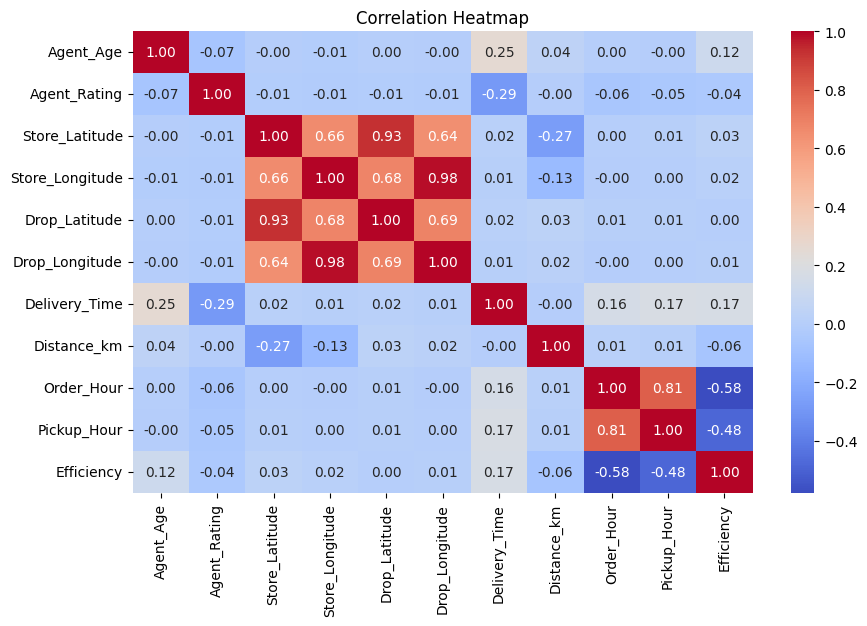

In [27]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

Insights:

Agent-Related Correlations

Agent Rating vs Delivery Time: A negative correlation (-0.29) → higher-rated agents tend to deliver faster.

Agent Age vs Delivery Time: A moderate positive correlation (0.25) → older agents may take slightly longer for deliveries.

Location Features

Store Latitude & Drop Latitude (0.93) and Store Longitude & Drop Longitude (0.98) → Very strong correlation since drop-off and pick-up points are geographically aligned.

This suggests redundancy, meaning dimensionality reduction (e.g., PCA) or dropping one set of coordinates might be useful.

Delivery Time Drivers

Weak correlations with Distance_km (0.00) → Suggests distance alone does not strongly affect delivery time (consistent with your earlier scatterplot finding).

Slight positive correlation with Efficiency (0.17) → less efficient routes/vehicles slightly increase delivery time.

Solutions To Employ:

Agent Rating is a strong performance signal → can be used as a feature in predictive ML models for delivery time.

Location coordinates are highly correlated → can be simplified to reduce dimensionality without losing information.

Distance does not strongly impact Delivery Time, but efficiency improves with longer distances → urban/short trips face more delays due to traffic, while long hauls benefit from smoother routes.

Peak Hours reduce efficiency → scheduling optimization and demand balancing strategies are critical.

Older agents may need additional support (e.g., smaller zones, better routing tools) to match younger agents' performance.

## **Agent Performance across Conditions**

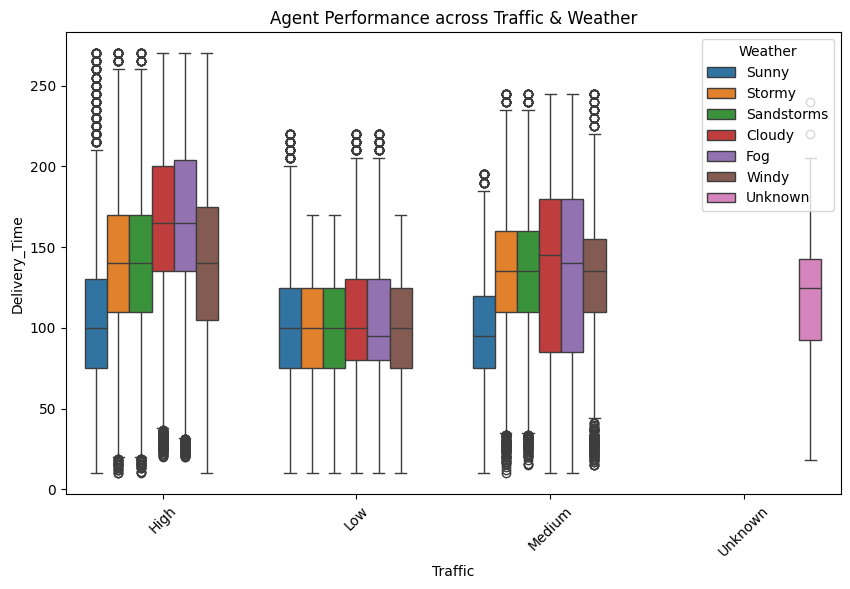

In [28]:
plt.figure(figsize=(10,6))
sns.boxplot(x='Traffic', y='Delivery_Time', hue='Weather', data=df)
plt.title('Agent Performance across Traffic & Weather')
plt.xticks(rotation=45)
plt.show()

Insights:

Traffic Effect Remains Strong

High traffic consistently results in the highest delivery times across all weather conditions.

Low traffic yields the fastest and most consistent deliveries.

Weather Influence

Sunny weather → Lowest delivery times and least variability across all traffic conditions (agents perform best).

Stormy, Foggy, and Cloudy weather → Higher median delivery times and wider spreads, meaning more uncertainty and delays.

Sandstorms/Windy conditions → Show significant delays, especially when combined with high traffic.

Unknown weather → Delivery times are mid-range but inconsistent, indicating possible data quality issues.

Combined Effects of Traffic + Weather

Under High Traffic + Bad Weather (Fog, Storm, Wind, Sandstorms), delivery times spike dramatically (often above 200 minutes).

Under Low/Medium Traffic + Sunny Weather, delivery times are shortest and most predictable.

Variability & Outliers

Weather adds greater variability to delivery times compared to traffic alone.

Many outliers appear under bad weather conditions, reflecting extreme delays (likely operational breakdowns, blocked roads, or safety precautions).

Solutions To Employ:

Need weather-aware logistics planning — rerouting, rescheduling, or adjusting expected delivery times during bad weather.

Customer communication is crucial: proactively inform about expected delays in case of traffic + adverse weather.

Sunny conditions can be leveraged for priority orders — ensure VIP/express deliveries are planned more during favorable weather.

Investing in better route optimization & forecasting tools will reduce delays caused by unpredictable weather and congestion.

In [29]:
# Final Shape
print("Prepared shape:", df.shape)

Prepared shape: (43739, 21)


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43739 entries, 0 to 43738
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Order_ID         43739 non-null  object        
 1   Agent_Age        43739 non-null  int64         
 2   Agent_Rating     43739 non-null  float64       
 3   Store_Latitude   43739 non-null  float64       
 4   Store_Longitude  43739 non-null  float64       
 5   Drop_Latitude    43739 non-null  float64       
 6   Drop_Longitude   43739 non-null  float64       
 7   Order_Date       43739 non-null  datetime64[ns]
 8   Order_Time       43739 non-null  object        
 9   Pickup_Time      43739 non-null  object        
 10  Weather          43739 non-null  object        
 11  Traffic          43739 non-null  object        
 12  Vehicle          43739 non-null  object        
 13  Area             43739 non-null  object        
 14  Delivery_Time    43739 non-null  int64

In [31]:
# Mean by Weather
mean_by_weather = df.groupby('Weather')['Delivery_Time'].mean().sort_values(ascending=False)
mean_by_weather.to_csv(os.path.join(OUT_DIR, 'mean_delivery_by_weather.csv'))

In [32]:
 # Prepare dataset for modeling
features = ['Agent_Age','Agent_Rating','Distance_km','Order_Hour','Pickup_Hour',
            'Weather','Traffic','Vehicle','Area','Category','Order_DayOfWeek']

X = df[features].copy()
y = df['Delivery_Time'].astype(float)

In [33]:
# Fill missing categorical with 'Unknown'
for c in ['Weather','Traffic','Vehicle','Area','Category','Order_DayOfWeek']:
    X[c] = X[c].fillna('Unknown').astype(str)

In [34]:
# Numeric imputation (safe)
X['Agent_Age'] = X['Agent_Age'].fillna(X['Agent_Age'].median())
X['Agent_Rating'] = X['Agent_Rating'].fillna(X['Agent_Rating'].median())

In [35]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)

In [36]:
numeric_features = ['Agent_Age','Agent_Rating','Distance_km','Order_Hour','Pickup_Hour']
categorical_features = ['Weather','Traffic','Vehicle','Area','Category','Order_DayOfWeek']

In [37]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

In [38]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

In [39]:
# Models to train
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=200, random_state=RANDOM_STATE)
}

results = {}
pipelines = {}

In [40]:
 # MLflow experiment
if MLFLOW_AVAILABLE:
    mlflow.set_experiment("Delivery_Time_Prediction")
    print("MLflow active: experiment set.")

In [41]:
print("Training models...")

Training models...


In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assume preprocessing/encoding already done for df
X = df.drop('Delivery_Time', axis=1, errors='ignore')
y = df['Delivery_Time']

# For simplicity, drop non-numeric cols (should use proper encoding)
X = X.select_dtypes(include=[np.number]).dropna(axis=1, how='any')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    results[name] = {
        'RMSE': np.sqrt(mean_squared_error(y_test, preds)),
        'MAE': mean_absolute_error(y_test, preds),
        'R2': r2_score(y_test, preds)
    }
print(pd.DataFrame(results).T)

                        RMSE        MAE        R2
Linear Regression  45.188071  35.341987  0.233480
Random Forest       2.728183   0.411555  0.997206
Gradient Boosting   7.756549   5.406099  0.977415


In [43]:
if MLFLOW_AVAILABLE:
        with mlflow.start_run(run_name=name):
            mlflow.log_param("model", name)
            mlflow.log_param("n_train", len(X_train))
            mlflow.log_metric("mae", RMSE)
            mlflow.log_metric("rmse", MAE)
            mlflow.log_metric("r2", R2)
            mlflow.sklearn.log_model(pipeline, artifact_path="model_pipeline")

In [44]:
# Save metrics
metrics_df = pd.DataFrame(results).T
metrics_df.to_csv(os.path.join(OUT_DIR, "model_metrics.csv"))
print(metrics_df)

                        RMSE        MAE        R2
Linear Regression  45.188071  35.341987  0.233480
Random Forest       2.728183   0.411555  0.997206
Gradient Boosting   7.756549   5.406099  0.977415


In [45]:
# Choose best by RMSE
best_name = min(results.keys(), key=lambda k: results[k]['RMSE'])
best_model = models[best_name]
joblib.dump(best_model, os.path.join(OUT_DIR, "best_model.joblib"))
print("Best model:", best_name, "saved to", os.path.join(OUT_DIR, "best_model.joblib"))

Best model: Random Forest saved to output/best_model.joblib


In [46]:
print("All artifacts saved to:", OUT_DIR)

All artifacts saved to: output


In [47]:
!pip install streamlit

In [48]:
joblib.dump(best_model, "best_model.pkl",compress=3)

['best_model.pkl']

In [49]:
import streamlit as st

In [50]:
st.set_page_config(page_title="Amazon Delivery Time Predictor", page_icon="🚚")

st.title("🚚 Amazon Delivery Time Prediction App")
st.write("Predict estimated delivery time based on traffic, weather, and agent details.")

# Input Fields
traffic = st.selectbox("Traffic Level", ["Low", "Medium", "High", "Unknown"])
weather = st.selectbox("Weather Condition", ["Sunny", "Stormy", "Sandstorms", "Cloudy", "Fog", "Windy", "Unknown"])
agent_rating = st.slider("Agent Rating", 1.0, 5.0, 4.5)
agent_age = st.slider("Agent Age", 18, 60, 30)
distance_km = st.number_input("Distance (in km)", 0.0, 20000.0, 5.0)
order_hour = st.slider("Order Hour (24-hr format)", 0, 23, 12)
pickup_hour = st.slider("Pickup Hour (24-hr format)", 0, 23, 13)

2025-10-05 21:14:12.878 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-05 21:14:12.879 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-05 21:14:13.075 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-10-05 21:14:13.076 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-05 21:14:13.077 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-05 21:14:13.079 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-05 21:14:13.082 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn

In [51]:
# Create DataFrame
input_data = pd.DataFrame({
    "Traffic": [traffic],
    "Weather": [weather],
    "Agent_Rating": [agent_rating],
    "Agent_Age": [agent_age],
    "Distance_km": [distance_km],
    "Order_Hour": [order_hour],
    "Pickup_Hour": [pickup_hour]
})

In [52]:
from sklearn.preprocessing import LabelEncoder
le_traffic = LabelEncoder()
input_data['Traffic'] = le_traffic.fit_transform(input_data['Traffic'])
joblib.dump(le_traffic, 'le_traffic.pkl')

['le_traffic.pkl']

In [53]:
le_weather =LabelEncoder()
input_data['Weather'] = le_traffic.fit_transform(input_data['Weather'])
joblib.dump(le_weather, 'le_weather.pkl')

['le_weather.pkl']

In [54]:
if st.button("Predict Delivery Time"):
    prediction = model.predict(input_data)[0]
    st.success(f"Estimated Delivery Time: {prediction:.2f} minutes")

2025-10-05 21:14:13.221 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-05 21:14:13.223 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-05 21:14:13.223 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-05 21:14:13.224 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-05 21:14:13.226 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-05 21:14:13.226 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [55]:
st.markdown("---")
st.caption("Developed by Aayush Kaul")

2025-10-05 21:14:13.235 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-05 21:14:13.236 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-05 21:14:13.237 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-05 21:14:13.238 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-05 21:14:13.241 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-05 21:14:13.242 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()